In [ ]:
try:
    from tqdm import tqdm
    from wordcloud import WordCloud
    from nltk.corpus import stopwords
except:
    !pip install tqdm -q
    !pip install wordcloud -q
    !pip install nltk -q
    print("Installation successful...\nRestarting...")
    dbutils.library.restartPython()
    print(f"Libriaries installed and loaded successfully.")


Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Installation successful...
Restarting...
Libriaries installed and loaded successfully.


In [ ]:
from pyspark.ml.feature import Tokenizer
from pyspark.sql.functions import col, size, count, isnan, when

import os

import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from tqdm import tqdm
from wordcloud import WordCloud

import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Check if the file exists in the directory
file_path = '/databricks/driver/wikipedia.csv'
if os.path.exists(file_path):
    print("File 'wikipedia.csv' already exists.")
else:
    # If the file doesn't exist, download it
    !wget https://proai-datasets.s3.eu-west-3.amazonaws.com/wikipedia.csv
    print("File 'wikipedia.csv' downloaded successfully.")

--2024-03-18 16:28:48--  https://proai-datasets.s3.eu-west-3.amazonaws.com/wikipedia.csv
Resolving proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)... 52.95.156.48, 3.5.225.182
Connecting to proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)|52.95.156.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1003477941 (957M) [text/csv]
Saving to: ‘wikipedia.csv’

wikipedia.csv       100%[===================>] 956.99M  16.1MB/s    in 58s     

2024-03-18 16:29:47 (16.6 MB/s) - ‘wikipedia.csv’ saved [1003477941/1003477941]

File 'wikipedia.csv' downloaded successfully.


In [ ]:
# CREATE THE TABLE
dataset = pd.read_csv('/databricks/driver/wikipedia.csv')
spark_df = spark.createDataFrame(dataset)
spark_df = spark_df.drop("Unnamed: 0")
spark_df.write.saveAsTable("wikipedia")

In [ ]:
# explore the dataset
spark_df.show(5)

+--------------------+--------------------+--------------------+---------+
|               title|             summary|           documents|categoria|
+--------------------+--------------------+--------------------+---------+
|           economics|economics () is a...|economics () is a...|economics|
|index of economic...|this aims to be a...|this aims to be a...|economics|
|     cryptoeconomics|cryptoeconomics i...|cryptoeconomics i...|economics|
|economic impact a...|an economic impac...|an economic impac...|economics|
|      economic trend|economic trend ma...|economic trend ma...|economics|
+--------------------+--------------------+--------------------+---------+
only showing top 5 rows



In [ ]:
# Check for NULL values
print("Checking for NULL values:")
spark_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in spark_df.columns]).show()

# remove NULL values if they exist
spark_df = spark_df.dropna()

# show the updated dataset
print("Checking for NULL values after removing them:")
spark_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in spark_df.columns]).show()

Checking for NULL values:
+-----+-------+---------+---------+
|title|summary|documents|categoria|
+-----+-------+---------+---------+
|    0|    928|      928|        0|
+-----+-------+---------+---------+

Checking for NULL values after removing them:
+-----+-------+---------+---------+
|title|summary|documents|categoria|
+-----+-------+---------+---------+
|    0|      0|        0|        0|
+-----+-------+---------+---------+



In [ ]:
# explore the dataset
spark_df.printSchema()

root
 |-- title: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- documents: string (nullable = true)
 |-- categoria: string (nullable = true)



In [ ]:
# check the number of rows
rows = spark_df.count()
print(f"Number of rows: {rows}")

Number of rows: 152304


# Define some functions for a better readability

In [ ]:
def count_articles_by_category(spark_df, category: str, document: str = "documents") -> int:
    """
    Count the number of articles in a specified category.

    Parameters:
    - spark_df (DataFrame): Spark DataFrame containing the articles.
    - category (str): The category to filter the articles.
    - document (str, optional): The column containing the article documents. Default is "documents".

    Returns:
    - int: The number of articles in the specified category.
    """
    counting = spark_df.filter(spark_df.categoria == category) \
        .select(document) \
        .count()

    return counting


def avg_words_per_doc(spark_df, category):
    """
    Calculate the average number of words per document in a specified category.

    Parameters:
    - spark_df (DataFrame): Spark DataFrame containing the articles.
    - category (str): The category to filter the articles.

    Returns:
    - float: The average number of words per document in the specified category.
    """
    total_words = spark_df.filter(spark_df.categoria == category) \
        .select(size(col("words"))) \
        .agg({"size(words)": "sum"}) \
        .collect()[0][0]

    return total_words / count_articles_by_category(spark_df, category)


def max_words(spark_df, category):
    """
    Find the maximum number of words in a single document in a specified category.

    Parameters:
    - spark_df (DataFrame): Spark DataFrame containing the articles.
    - category (str): The category to filter the articles.

    Returns:
    - int: The maximum number of words in a single document in the specified category.
    """
    max_words_df = spark_df.filter(spark_df.categoria == category) \
        .select(size(col("words")).alias("num_words")) \
        .agg({"num_words": "max"})
    
    max_words = max_words_df.collect()[0][0] if max_words_df.count() > 0 else 0

    return max_words


def min_words(spark_df, category):
    """
    Find the minimum number of words in a single document in a specified category.

    Parameters:
    - spark_df (DataFrame): Spark DataFrame containing the articles.
    - category (str): The category to filter the articles.

    Returns:
    - int: The minimum number of words in a single document in the specified category.
    """
    min_words_df = spark_df.filter(spark_df.categoria == category) \
        .select(size(col("words")).alias("num_words")) \
        .agg({"num_words": "min"})
    
    min_words = min_words_df.collect()[0][0] if min_words_df.count() > 0 else 0
    return min_words


def define_category(spark_df, category):
    """
    Define the category of an article based on its title.

    Parameters:
    - spark_df (DataFrame): Spark DataFrame containing the articles.
    - category (str): The category to filter the articles.

    Returns:
    - int: The number of articles in the specified category.
    """
    return spark_df.filter(spark_df.categoria == category)

def tokenize_data(spark_df):
    """
    Tokenize the data.

    Parameters:
    - spark_df (DataFrame): Spark DataFrame containing the articles.

    Returns:
    - DataFrame: The Spark DataFrame with the tokenized data.
    """
    tokenizer = Tokenizer(inputCol="documents", outputCol="words")
    tokenized_df = tokenizer.transform(spark_df)

    return tokenized_df

def return_wordcloud(spark_df, category):
    """
    Generate a wordcloud for a specified category.

    Parameters:
    - spark_df (DataFrame): Spark DataFrame containing the articles.
    - category (str): The category to filter the articles.

    Returns:
    - list: A list of words in the wordcloud.
    """

    #A minimum of preprocessing is required 
    #to prevent the most representative words
    #from ending up as punctuation or stopwords
    def preprocess_text(text):
        """
        Preprocess the text by removing punctuation.

        Parameters:
        - text (str): The text to preprocess.

        Returns:
        - str: The preprocessed text.
        """
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        return text
    
    cat = spark_df.filter(spark_df.categoria == category)
    STOPWORDS = set(stopwords.words('english'))
    preprocessed_text = preprocess_text(str(cat.select("words").collect()[0][0]))
    wordcloud = WordCloud(stopwords=STOPWORDS, max_words=10).generate(preprocessed_text)
    return list(wordcloud.words_.keys())
    
    

In [ ]:
# Explore the categories
categories = spark_df.select("categoria").distinct().collect()
categories

[Row(categoria='economics'),
 Row(categoria='politics'),
 Row(categoria='culture'),
 Row(categoria='science'),
 Row(categoria='sports'),
 Row(categoria='energy'),
 Row(categoria='finance'),
 Row(categoria='humanities'),
 Row(categoria='pets'),
 Row(categoria='trade'),
 Row(categoria='technology'),
 Row(categoria='transport'),
 Row(categoria='medicine'),
 Row(categoria='engineering'),
 Row(categoria='research')]

In [ ]:
# Tokenize the data
tokenized_df = tokenize_data(spark_df)

In [ ]:
display(tokenized_df.show(5))

+--------------------+--------------------+--------------------+---------+--------------------+
|               title|             summary|           documents|categoria|               words|
+--------------------+--------------------+--------------------+---------+--------------------+
|           economics|economics () is a...|economics () is a...|economics|[economics, (), i...|
|index of economic...|this aims to be a...|this aims to be a...|economics|[this, aims, to, ...|
|     cryptoeconomics|cryptoeconomics i...|cryptoeconomics i...|economics|[cryptoeconomics,...|
|economic impact a...|an economic impac...|an economic impac...|economics|[an, economic, im...|
|      economic trend|economic trend ma...|economic trend ma...|economics|[economic, trend,...|
+--------------------+--------------------+--------------------+---------+--------------------+
only showing top 5 rows



In [ ]:
if 'stats_df.csv' in os.listdir('/databricks/driver/'):
    stats_df = pd.read_csv("/databricks/driver/stats_df.csv")
    print('Dataset Loaded successfully!')
else:
    print('Dataset not found...Building dataset...')
    # Initialize an empty dictionary to store statistics
    data = {'category': [], 'tot_articles': [], 'avg_num_words': [], 'max_words': [], 'min_words': [],"WordCloud":[]}


    # Iterate over categories
    for category in tqdm(categories, desc="Processing categories"):
        count = count_articles_by_category(tokenized_df, category[0])
        avg = avg_words_per_doc(tokenized_df, category[0])
        longest_article = max_words(tokenized_df, category[0])
        shortest_article = min_words(tokenized_df, category[0])
        wordcloud = return_wordcloud(tokenized_df, category[0])
        
        # Append statistics to the data dictionary
        data['category'].append(category[0])
        data['tot_articles'].append(count)
        data['avg_num_words'].append(avg)
        data['max_words'].append(longest_article)
        data['min_words'].append(shortest_article)
        data["WordCloud"].append(wordcloud)

    # Create a DataFrame from the data dictionary
    stats_df = pd.DataFrame(data)



Dataset not found...Building dataset...


Processing categories: 100%|██████████| 15/15 [14:08<00:00, 56.53s/it]


In [ ]:
# Define the file path for the CSV file
csv_file_path = "/databricks/driver/stats_df.csv"  # Change the file path as needed

# save the dataset
stats_df.to_csv(csv_file_path, index=False)



<div style="background-color:#f9f9f9; padding:10px; border-radius:5px; border: 1px solid #e0e0e0;">
    <p style="color:#333; font-size:16px;"><strong>Below is a quick graphical analysis of the dataframe created.</strong></p>
    <p style="color:#777;">NOTE: For the creation of the WordCloud a minimum of preprocessing was done to avoid getting stopwords, punctuation, etc. as the most frequent words... For everything else no preprocessing was done.</p>
</div>

In [ ]:
stas_df = pd.read_csv("stats_df.csv")
stas_df

,category,tot_articles,avg_num_words,max_words,min_words,WordCloud
0,economics,10110,984.204946,24022,10,"['economic', 'market', 'price', 'good', 'theor..."
1,politics,11358,1515.651699,20140,11,"['political', 'politic', 'state', 'social', 'g..."
2,culture,10155,653.866371,15538,11,"['culture', 'cultural', 'social', 'cultural st..."
3,science,10166,1875.616172,29419,15,"['science', 'scientific', 'research', 'natural..."
4,sports,10066,602.109378,19227,14,"['sport', 'game', 'also', 'participation', 'ol..."
5,energy,10033,587.451311,23223,9,"['energy', 'system', 'heat', 'form', 'potentia..."
6,finance,9863,1909.892426,33479,3,"['finance', 'financial', 'investment', 'risk',..."
7,humanities,10116,1059.731811,23198,7,"['humanities', 'art', 'history', 'science', 's..."
8,pets,10016,423.104932,13222,12,"['pet', 'animal', 'dog', 'owner', 'cat', 'kept..."
9,trade,10064,641.151828,19275,16,"['trade', 'world', 'economic', 'trading', 'goo..."



#### The dataset is balanced

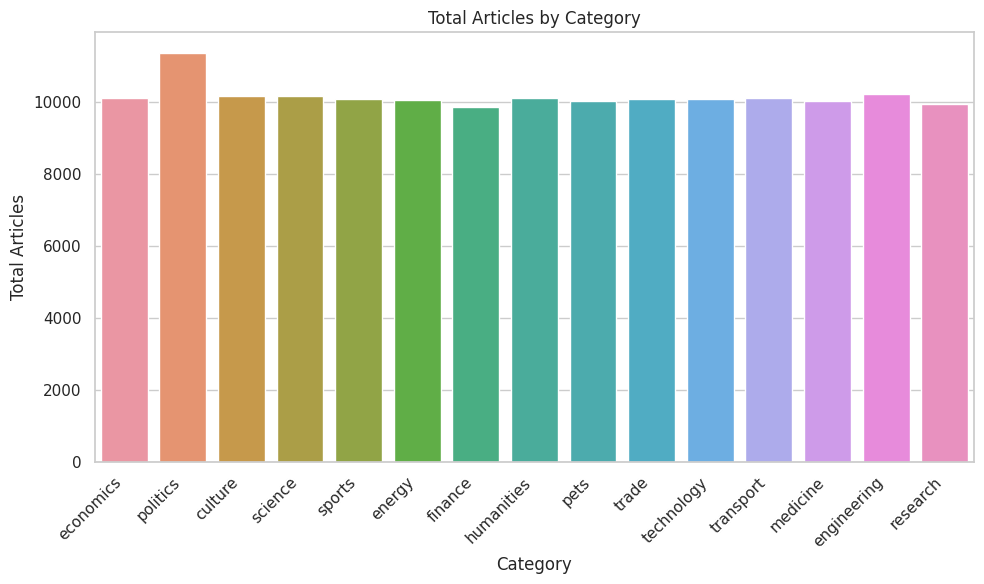

In [ ]:
# Compare total articles
# Set style and context for better aesthetics
sns.set_style("whitegrid")
sns.set_context("notebook")

# Plot the barplot
plt.figure(figsize=(10, 6))
sns.barplot(x="category", y="tot_articles", data=stats_df, errorbar='sd', capsize=0.1)
plt.title("Total Articles by Category")
plt.xlabel("Category")
plt.ylabel("Total Articles")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

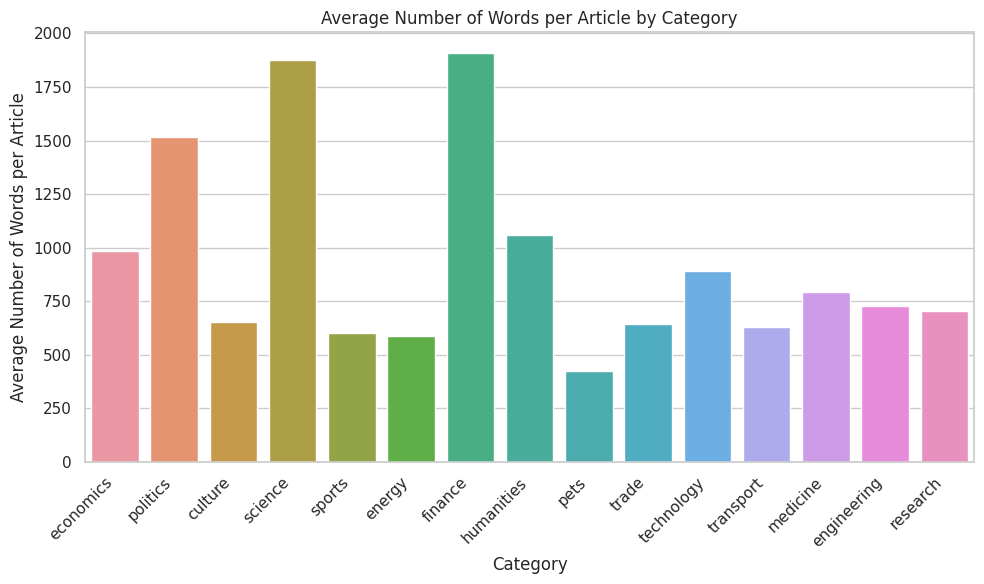

In [ ]:
# Compare average number of words per article
plt.figure(figsize=(10, 6))
sns.barplot(x="category", y="avg_num_words", data=stats_df)
plt.title("Average Number of Words per Article by Category")
plt.xlabel("Category")
plt.ylabel("Average Number of Words per Article")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

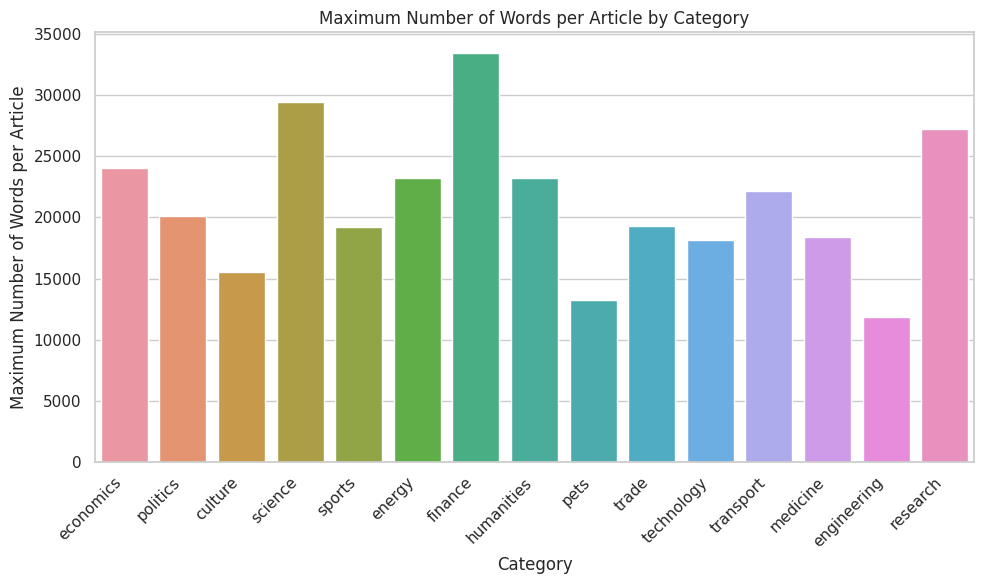

In [ ]:
# Compare maximum number of words per article
plt.figure(figsize=(10, 6))
sns.barplot(x="category", y="max_words", data=stats_df)
plt.title("Maximum Number of Words per Article by Category")
plt.xlabel("Category")
plt.ylabel("Maximum Number of Words per Article")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

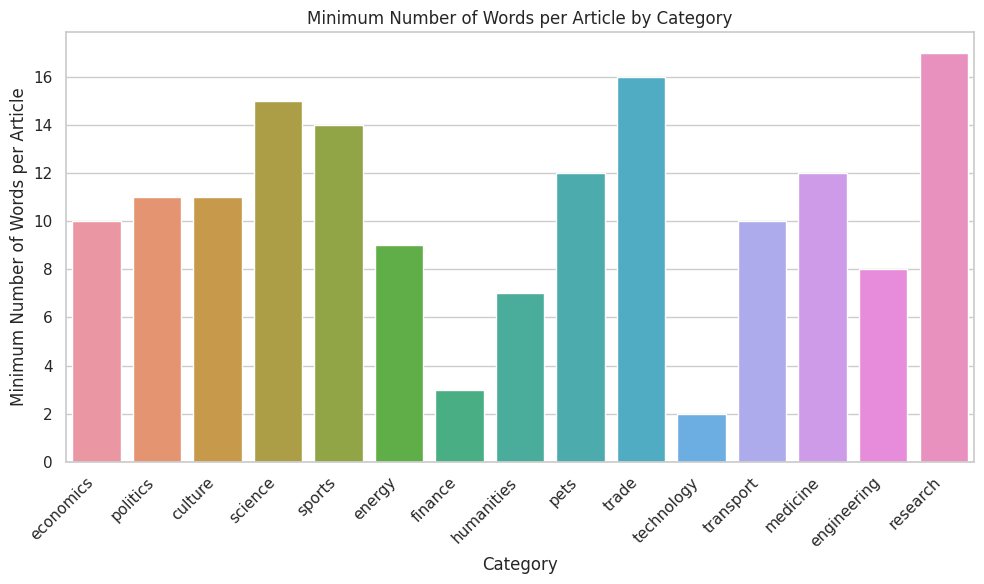

In [ ]:
# Compare minimum number of words per article
plt.figure(figsize=(10, 6))
sns.barplot(x="category", y="min_words", data=stats_df)
plt.title("Minimum Number of Words per Article by Category")
plt.xlabel("Category")
plt.ylabel("Minimum Number of Words per Article")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [ ]:
tokenized_df.show(5)

+--------------------+--------------------+--------------------+---------+--------------------+
|               title|             summary|           documents|categoria|               words|
+--------------------+--------------------+--------------------+---------+--------------------+
|           economics|economics () is a...|economics () is a...|economics|[economics, (), i...|
|index of economic...|this aims to be a...|this aims to be a...|economics|[this, aims, to, ...|
|     cryptoeconomics|cryptoeconomics i...|cryptoeconomics i...|economics|[cryptoeconomics,...|
|economic impact a...|an economic impac...|an economic impac...|economics|[an, economic, im...|
|      economic trend|economic trend ma...|economic trend ma...|economics|[economic, trend,...|
+--------------------+--------------------+--------------------+---------+--------------------+
only showing top 5 rows



# Prepare data for classification

- ### In this first experiment we try to train a classifier using these columns:

    - `title` 
    - `summary`
    - `categoria` (*as target variable*)

In [ ]:
# import libraries
from pyspark.ml.feature import Tokenizer, StopWordsRemover, IDF, VectorAssembler,HashingTF, StringIndexer,StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import NaiveBayes

In [ ]:
# Remove documents from the data
spark_df_classy = spark_df.select("title", "summary", "categoria")

#### Define a pipeline for preprocessing and classification

In [ ]:
# Tokenize the data
tokenizer_sm = Tokenizer(inputCol="summary", outputCol="summary_words")
tokenizer_title = Tokenizer(inputCol="title", outputCol="title_words")

# Remove stop words
remover_summary = StopWordsRemover(inputCol="summary_words", outputCol="summary_filtered")
remover_title = StopWordsRemover(inputCol="title_words", outputCol="title_filtered")

# Use TFIDF on title
TF_title = HashingTF(inputCol="title_filtered", outputCol="title_tf")
idf_title = IDF(inputCol="title_tf", outputCol="title_tfidf")

# Use TFIDF on summary
TF_summary = HashingTF(inputCol="summary_filtered", outputCol="summary_tf")
idf_summary = IDF(inputCol="summary_tf", outputCol="summary_tfidf")

# Combine title and summary
assembler = VectorAssembler(inputCols=["title_tfidf", "summary_tfidf"], outputCol="features")

# Standard scaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# Process the target variable
label_stringIdx = StringIndexer(inputCol = "categoria", outputCol = "label")

# Model
bayes = NaiveBayes(featuresCol="scaledFeatures", labelCol="label")

# Pipeline
model_pipeline = Pipeline(stages=[tokenizer_sm,
                            remover_summary,
                            TF_summary,idf_summary,
                            tokenizer_title,
                            remover_title,
                            TF_title,idf_title,
                            assembler,
                            scaler,
                            label_stringIdx,
                            bayes])

In [ ]:
# Split the dataset
train,test = spark_df_classy.randomSplit([0.8,0.2],seed=42)

In [ ]:
model = model_pipeline.fit(train)

In [ ]:
# Test accuracy of test set
prediction = model.transform(test)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(prediction)
print("Test set accuracy = " + str(accuracy))

Test set accuracy = 0.8347449215906835


- # 2nd Experiment using columns:

    - `title` 
    - **`documents`** (instead of *summary*)
    - `categoria` (*as target variable*)


In [ ]:
spark_df_2 = spark_df.select("title", "documents", "categoria")

In [ ]:
train,test = spark_df_2.randomSplit([0.8,0.2],seed=42)

#### Define the 2nd pipeline

In [ ]:
# Tokenize the data
tokenizer_dc = Tokenizer(inputCol="documents", outputCol="documents_words")
tokenizer_title = Tokenizer(inputCol="title", outputCol="title_words")

# Remove stop words
remover_documents = StopWordsRemover(inputCol="documents_words", outputCol="documents_filtered")
remover_title = StopWordsRemover(inputCol="title_words", outputCol="title_filtered")

# Use TFIDF on title
TF_title = HashingTF(inputCol="title_filtered", outputCol="title_tf")
idf_title = IDF(inputCol="title_tf", outputCol="title_tfidf")

# Use TFIDF on summary
TF_documents = HashingTF(inputCol="documents_filtered", outputCol="documents_tf")
idf_documents = IDF(inputCol="documents_tf", outputCol="documents_tfidf")

# Combine title and summary
assembler = VectorAssembler(inputCols=["title_tfidf", "documents_tfidf"], outputCol="features")

# Standard scaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# Process the target variable
label_stringIdx = StringIndexer(inputCol = "categoria", outputCol = "label")

# Model
bayes = NaiveBayes(featuresCol="scaledFeatures", labelCol="label")

# Pipeline
model_pipeline = Pipeline(stages=[tokenizer_dc,
                            remover_documents,
                            TF_documents,idf_documents,
                            tokenizer_title,
                            remover_title,
                            TF_title,idf_title,
                            assembler,
                            scaler,
                            label_stringIdx,
                            bayes])

In [ ]:
model_2 = model_pipeline.fit(train)

In [ ]:
# Evaluate the model
prediction = model_2.transform(test)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(prediction)
print("Test set accuracy = " + str(accuracy))

Test set accuracy = 0.8521471580758287


### Test the models obtained

In [ ]:

title_article = 'Global Supply Chain Disruptions: Navigating the Economic Impact'
corpus = """

As the world grapples with ongoing supply chain disruptions, economists are closely monitoring the unfolding economic consequences. From factory closures to port delays, the intricate web of global trade is facing unprecedented challenges, impacting industries and consumers alike.

One of the primary drivers behind these disruptions is the lingering effects of the COVID-19 pandemic. Lockdowns, labor shortages, and logistical hurdles have rippled through supply chains, causing bottlenecks and shortages in various sectors. Additionally, geopolitical tensions and natural disasters have further strained the system, exacerbating the situation.

The repercussions of these disruptions are manifold. Businesses are facing increased costs and uncertainty, leading to price hikes and supply shortages. Consumers are feeling the pinch as well, experiencing delays in receiving goods and higher prices for essential items. Inflationary pressures are mounting, posing challenges for central banks striving to maintain price stability.

However, amidst the challenges lie opportunities for innovation and resilience. Companies are reevaluating their supply chain strategies, diversifying suppliers, and investing in digitalization to enhance agility and adaptability. Governments are also stepping in with policy interventions to mitigate the impact and bolster supply chain resilience.

Looking ahead, navigating these supply chain disruptions will require collaborative efforts from stakeholders across the globe. Proactive measures to address vulnerabilities, enhance transparency, and foster cooperation will be essential in building a more robust and resilient global economy.

In conclusion, while supply chain disruptions pose significant economic challenges, they also present opportunities for adaptation and growth. By embracing innovation and cooperation, the global economy can weather the storm and emerge stronger in the face of future uncertainties.

"""

In [ ]:
def make_prediction(title, corpus, pipeline, column2):
    """
    Make a prediction using the provided title, corpus, and pipeline.

    Args:
    - title (str): The title of the article.
    - corpus (str): The content of the article.
    - pipeline (PipelineModel): The trained pipeline model for text classification.
    - column2 (str): summary or documents.

    Returns:
    - predicted_label (str): The predicted label for the given article.

    """
    # Create a DataFrame from the provided title, corpus, and column2
    data = [(title, corpus)]
    columns = ["title", column2]
    article_df = spark.createDataFrame(data, columns)
    
    # Transform the input data using the provided pipeline
    transformed_data = pipeline.transform(article_df)
    
    # Retrieve the predicted label using the pipeline
    prediction_idx = int(transformed_data.select('prediction').collect()[0][0])
    original_labels = pipeline.stages[10].labels
    predicted_label = original_labels[prediction_idx]

    return predicted_label

In [ ]:
# Try to make prediction using the model trained on summary
make_prediction(title_article, corpus,model,'summary')

'technology'

In [ ]:
# Try to make a prediction using the model trained on documents
make_prediction(title_article, corpus,model_2,'documents')

'energy'